<center> <span style="color:indigo">Métodos Estadíticos Básicos</span> </center> 

<div style="text-align: center;">
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5e/Logo-cucea.png" alt="Drawing" style="width: 800px;"/>
</div>

<center> <span style="color:DarkBlue">  Tema 2. Regresión lineal: variables categóricas </span>  </center>
<center> <span style="color:Blue"> Profesor: M. en C. Iván A. Toledano Juárez </span>  </center>

# El tratamiento de las variables categóricas

Hasta ahora has trabajado con variables numéricas en modelos de regresión, pero en problemas reales es muy común encontrarse con información **categórica**: desde el tipo de dispositivo que usa un cliente, hasta su género, región o preferencia de compra. En este notebook vas a aprender cómo incluir ese tipo de variables en un modelo de **regresión lineal usando `scikit-learn`**, de manera eficiente.

Trabajaremos con un dataset simulado de comercio electrónico llamado `ecom_simulated`, que representa situaciones cercanas a aplicaciones reales. Verás cómo convertir variables categóricas en datos que un modelo puede entender, entrenarás un modelo de regresión con ellas, y sobre todo, **aprenderás a interpretar sus resultados en ese contexto**. Además, analizaremos cómo cambian los coeficientes del modelo según la codificación, y qué significa que una categoría quede como referencia.

Posteriormente, aplicaremos lo aprendido en otro notebook utilizando el dataset clásico `mtcars`, donde exploraremos cómo aplicar **transformaciones logarítmicas** sobre variables numéricas para mejorar el ajuste del modelo y capturar relaciones que no son lineales a simple vista.

Este ejercicio no solo te permitirá ampliar tu dominio de la regresión lineal, sino que también te prepara para trabajar con conjuntos de datos más diversos y realistas, como los que enfrentarás en proyectos o competencias de machine learning.

In [1]:
# Importación de librerías
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## Importación de datos

In [2]:
mainpath = "../data/"
filename = "ecom_simulated/ecom.csv"
fullpath = os.path.join(mainpath,filename)

df_ecom = pd.read_csv(fullpath)

# Este dataframe tiene unos espacios innecesarios en las variables
df_ecom = df_ecom.rename(columns={"Age ": "Age", " Items ": "Items"})

df_ecom.head()

,Transaction ID,Age,Items,Monthly Income,Transaction Time,Record,Gender,City Tier,Total Spend
0,TXN001,42,10,7313,627.668127,5,Female,Tier 1,4198.385084
1,TXN002,24,8,17747,126.904567,3,Female,Tier 2,4134.976648
2,TXN003,47,11,22845,873.469701,2,Male,Tier 2,5166.614455
3,TXN004,50,11,18552,380.219428,7,Female,Tier 1,7784.447676
4,TXN005,60,2,14439,403.374223,2,Female,Tier 2,3254.160485


In [3]:
df_ecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    2362 non-null   object 
 1   Age               2362 non-null   int64  
 2   Items             2362 non-null   int64  
 3   Monthly Income    2362 non-null   int64  
 4   Transaction Time  2362 non-null   float64
 5   Record            2362 non-null   int64  
 6   Gender            2362 non-null   object 
 7   City Tier         2362 non-null   object 
 8   Total Spend       2362 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 166.2+ KB


In [4]:
df_ecom.isna().any() # no hay valores nulos

Transaction ID      False
Age                 False
Items               False
Monthly Income      False
Transaction Time    False
Record              False
Gender              False
City Tier           False
Total Spend         False
dtype: bool

In [5]:
df_ecom.describe()

,Age,Items,Monthly Income,Transaction Time,Record,Total Spend
count,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000
mean,40.084674,7.884843,15962.884843,497.429603,4.928874,6163.176416
std,11.973412,4.283014,8046.517234,286.065147,3.084855,2799.772060
min,20.000000,1.000000,2003.000000,0.463297,0.000000,1099.815246
25%,30.000000,4.000000,9086.750000,253.443599,2.000000,3949.683101
50%,40.000000,8.000000,15764.000000,495.098046,5.000000,5602.193897
75%,51.000000,12.000000,23056.750000,745.833710,7.750000,8046.755618
max,60.000000,15.000000,30000.000000,1000.697201,10.000000,13944.048160


Tenemos datos simulados de un sitio de e-commerce, que captura la información de varias transacciones realizadas en la plataforma.


* **Transaction ID**: Identificador de la transacción

* **Age**: Edad del cliente

* **Items**: número de artículos en el carrito (comprados)

* **Monthly Income**: cantidad monetaria mensual para gastos

* **Transaction time**: tiempo total que se estuvo en el website durante la transaccion

* **Record**: Cuantas veces el cliente ha comprado en el website en el pasado.

* **Gender**: género del cliente

* **City tier**: 

* **Total Spend**: cantidad monetaria total asociada a la transacción.

Tenemos datos de transacción, la edad del cliente, items que ha comprado, tiempo de transacción y género, el tipo de ciudad así como el gasto total. Registros financieros de un banco, y queremos predecir los gastos de un mes en particular basado en si vive en un barrio de buena clase o no, si es hombre o no.  Tanto el género como el city tier son variables categóricas.

## 🎯 Codificando variables categóricas: dummy variables

Para que un modelo de regresión lineal pueda trabajar con variables categóricas como el `Gender` o el `City Tier`, necesitamos transformarlas en variables numéricas. Esto lo hacemos mediante **codificación dummy**, que convierte cada categoría en una nueva columna que toma el valor 1 si se cumple y 0 si no.

En este caso usamos `pandas.get_dummies()` con el argumento `drop_first=True`, lo que significa que **omitimos una de las categorías como referencia**. Esto es importante porque evita que las variables codificadas estén perfectamente correlacionadas entre sí (colinealidad perfecta), algo que podría afectar el modelo. La categoría omitida se convierte en la base con la cual se comparan las demás.

Más adelante, cuando interpretemos el modelo, podremos entender qué significa tener `Gender_Male = 1` o `City Tier_2 = 1`, siempre en comparación con la categoría que quedó fuera.


In [6]:
## Creación de las variables dummy con pandas

df_ecom= pd.get_dummies(df_ecom, columns=['Gender'], drop_first=True, dtype=int)
df_ecom= pd.get_dummies(df_ecom, columns=['City Tier'], drop_first=True, dtype=int)

# El argumento drop_first remueve la primer categoría que se encuentra, para no tener información redundante

# Verificamos el resultado
display(df_ecom.head(5))

,Transaction ID,Age,Items,Monthly Income,Transaction Time,Record,Total Spend,Gender_Male,City Tier_Tier 2,City Tier_Tier 3
0,TXN001,42,10,7313,627.668127,5,4198.385084,0,0,0
1,TXN002,24,8,17747,126.904567,3,4134.976648,0,1,0
2,TXN003,47,11,22845,873.469701,2,5166.614455,1,1,0
3,TXN004,50,11,18552,380.219428,7,7784.447676,0,0,0
4,TXN005,60,2,14439,403.374223,2,3254.160485,0,1,0


Por ejemplo, en este caso, si la variable `Gender` se convierte en `Gender_Male`, su coeficiente en el modelo indicará cómo cambia la variable respuesta cuando el género es masculino, **en comparación con la categoría omitida** (que sería `Female`, en este caso). Este paso es clave para poder incluir variables categóricas correctamente en un modelo lineal sin caer en problemas de colinealidad.

> ⚠️ **Importante:** cuando usamos `drop_first=True` para eliminar una de las categorías de una variable categórica, es fundamental **prestar atención a cuál categoría se está eliminando**, ya que será la que se utilice como **categoría de referencia** en la interpretación del modelo. Esta decisión afecta directamente el significado de los coeficientes.

Esto cobra especial importancia cuando una variable tiene **más de dos categorías** (por ejemplo, `City Tier` con valores `1`, `2` y `3`). En ese caso, una de ellas será descartada automáticamente, y todas las demás se interpretarán en relación con esa categoría. Si no verificamos explícitamente cuál fue removida, podríamos malinterpretar los resultados o incluso cometer errores al comunicar las conclusiones del modelo.

Para evitar confusiones, es buena práctica **revisar con `df.dtypes` y `df.columns` el resultado de `get_dummies()`** y, si se desea mayor control, usar el argumento `categories` con `OneHotEncoder` o crear las dummies manualmente especificando el orden de referencia.

## Codificando variables categóricas con `OneHotEncoder`

Otra forma muy común y flexible de transformar variables categóricas para modelos de machine learning es usando `OneHotEncoder`, una herramienta incluida en `scikit-learn`. A diferencia de `pandas.get_dummies()`, que transforma directamente un `DataFrame`, `OneHotEncoder` es especialmente útil cuando trabajamos con **pipelines automatizados** o queremos integrar el preprocesamiento dentro del flujo completo de modelado.

Este codificador crea nuevas columnas binarias para cada categoría de las variables seleccionadas, igual que `get_dummies()`, y también permite eliminar una categoría por variable con `drop='first'` para evitar colinealidad. Una ventaja adicional es que `OneHotEncoder` puede usarse junto con `ColumnTransformer`, lo que nos da un control más fino para aplicar transformaciones diferentes a columnas numéricas y categóricas dentro del mismo pipeline.

En este notebook lo utilizaremos para transformar variables como `Gender` y `City Tier`, dejando nuestras variables listas para ser utilizadas en modelos de regresión lineal u otros algoritmos de aprendizaje automático.


In [7]:
df_ecom.columns

Index(['Transaction ID', 'Age', 'Items', 'Monthly Income', 'Transaction Time',
       'Record', 'Total Spend', 'Gender_Male', 'City Tier_Tier 2',
       'City Tier_Tier 3'],
      dtype='object')

In [8]:
## Con OneHotEncoder

# Carga de datos
filename = "ecom_simulated/ecom.csv"
fullpath = os.path.join(mainpath,filename)
df_ecom = pd.read_csv(fullpath)
df_ecom = df_ecom.rename(columns={"Age ": "Age", " Items ": "Items"})

# Seleccionamos las columnas categóricas y numéricas
categorical_cols = ['Gender', 'City Tier'] # omitimos variable 'Transaction ID', pues no aporta información
numerical_cols = ['Age', 'Items', 'Monthly Income', 'Transaction Time', 'Record', 'Total Spend']

# Creamos el dataframe que queremos codificar
# En este caso es el dataframe original pero sin la variable 'Transaction ID'
df_ecom = df_ecom[categorical_cols + numerical_cols]

# Instanciamos el codificador OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False, dtype=int)

# Aplicamos la codificación con ColumnTransformer
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', ohe, categorical_cols)
    ],
    remainder='passthrough'  # deja pasar las columnas numéricas sin cambios
)

# Aplicamos el transformador
X_encoded = column_transformer.fit_transform(df_ecom)

# Recuperamos los nombres de las columnas dummy codificadas
encoded_col_names = column_transformer.named_transformers_['cat'].get_feature_names_out(categorical_cols)

# Combinamos nombres codificados y los que pasaron directamente
final_columns = list(encoded_col_names) + numerical_cols  # agregar nombres de las columnas que pasaron sin transformación

# Convertimos a DataFrame para inspección
df_ecom_encoded = pd.DataFrame(X_encoded, columns=final_columns)

# Mostramos las primeras filas
df_ecom_encoded.head()

,Gender_Male,City Tier_Tier 2,City Tier_Tier 3,Age,Items,Monthly Income,Transaction Time,Record,Total Spend
0,0.0,0.0,0.0,42.0,10.0,7313.0,627.668127,5.0,4198.385084
1,0.0,1.0,0.0,24.0,8.0,17747.0,126.904567,3.0,4134.976648
2,1.0,1.0,0.0,47.0,11.0,22845.0,873.469701,2.0,5166.614455
3,0.0,0.0,0.0,50.0,11.0,18552.0,380.219428,7.0,7784.447676
4,0.0,1.0,0.0,60.0,2.0,14439.0,403.374223,2.0,3254.160485


## Comparación: `get_dummies()` vs `OneHotEncoder`

Al final, tanto `pandas.get_dummies()` como `OneHotEncoder` generan columnas similares: **variables binarias que representan a las categorías**. La diferencia real **no está en el resultado**, sino en el **contexto de uso** en **cómo se integran dentro flujos de machine learning más complejos**. A continuación se presenta una tabla comparativa.

| Aspecto                                             | `pandas.get_dummies()`                     | `OneHotEncoder` + `ColumnTransformer`         |
|-----------------------------------------------------|--------------------------------------------|-----------------------------------------------|
| Funciona directamente con `DataFrame`               | ✅ Sí                                       | ❌ No (trabaja sobre arrays)                   |
| Fácil de usar para exploración rápida               | ✅ Muy cómodo                               | ❌ Requiere pasos adicionales                 |
| Compatible con `Pipeline` de `scikit-learn`         | ❌ No se integra automáticamente            | ✅ Sí, totalmente compatible                   |
| Permite reutilizar (`fit`/`transform`)              | ❌ No                                       | ✅ Sí                                          |
| Evita fugas de datos en validación cruzada          | ❌ Se requiere cuidado manual               | ✅ Integración automática en validación        |
| Consistencia entre entrenamiento y prueba           | ❌ Hay que codificar manualmente            | ✅ Se garantiza dentro del pipeline            |
| Control preciso de columnas a transformar           | ✅ Parcial (con `columns=`)                | ✅ Total con `ColumnTransformer`              |
| Ideal para notebooks y análisis exploratorios       | ✅ Sí                                       | ❌ No necesariamente                           |
| Ideal para producción, despliegue y automatización  | ❌ No                                       | ✅ Sí                                          |

* Usa `get_dummies()` si estás:
    * Explorando los datos de forma rápida o visual
    * Trabajando en un notebook demostrativo
    * Necesitas algo simple y directo
* Usa `OneHotEncoder` si:
    * Estas construyendo un **pipeline completo de machine learning**
    * Quieres juntar en un pipeline una validación cruzada, o búsqueda de hiperparámetros
    * Vas a exportar el modelo para producción o reutilizarlo
    * Quiero que todo el procesamiento esté integrado en el modelo

## Entrenamiento del modelo de regresión lineal

Una vez que nuestras variables categóricas han sido transformadas en variables numéricas mediante codificación dummy, ya podemos entrenar un modelo de **regresión lineal** utilizando `scikit-learn`. En este caso, el modelo se encargará de aprender cómo las diferentes variables —tanto numéricas como categóricas codificadas— se relacionan con la variable objetivo (por ejemplo, el monto de compra).

El proceso es el mismo que en modelos anteriores: seleccionamos las columnas predictoras (`X`), definimos la variable respuesta (`y`), instanciamos el modelo con `LinearRegression()`, lo entrenamos con `.fit()`, y evaluamos su rendimiento usando métricas como $$R^2$$, el error cuadrático medio (MSE) y su raíz cuadrada (RMSE). Este modelo ya está listo para hacer predicciones y comenzar a interpretarse.


In [9]:
# Hacemos una lista de las variables predictoras que queremos incluir
feature_cols = ["Monthly Income", "Transaction Time", "Gender_Male", "City Tier_Tier 2", "City Tier_Tier 3"]

In [10]:
# Matriz de características X, y la variable objetivo y
X = df_ecom_encoded[feature_cols]
y = df_ecom_encoded["Total Spend"]

In [11]:
lm = LinearRegression() # instanciamos el modelo, y sus parámetros
model = lm.fit(X,y) # entrenamos el modelo

In [12]:
# Imprimimos sus parámetros de ajuste
print('ß0: ', round(lm.intercept_,3))
for i in range(0, len(lm.coef_)):
    print('ß'+str(i+1)+': ', round(lm.coef_[i],3), 'asociado a variable', lm.feature_names_in_[i])

ß0:  3681.235
ß1:  0.153 asociado a variable Monthly Income
ß2:  0.124 asociado a variable Transaction Time
ß3:  188.316 asociado a variable Gender_Male
ß4:  -136.342 asociado a variable City Tier_Tier 2
ß5:  -222.647 asociado a variable City Tier_Tier 3


In [13]:
# Si queremos, incluso podemos juntar estos valores en una lista
list(zip(feature_cols,lm.coef_))

[('Monthly Income', np.float64(0.15297824609320482)),
 ('Transaction Time', np.float64(0.12372608642590247)),
 ('Gender_Male', np.float64(188.31559766064015)),
 ('City Tier_Tier 2', np.float64(-136.3422696118916)),
 ('City Tier_Tier 3', np.float64(-222.64748519981194))]

De esta forma, el modelo lineal propuesto sería el siguiente:

\begin{equation}
\rm{Total \ Spend} = 3681.235 + 0.153 \ \rm{Monthly \ Income} + 0.124 \ \rm{Transaction \ Time} + 188.316 \ \rm{Gender\_Male} - 136.342\rm \ {City \ Tier\_Tier \ 2} - 222.647 \ \rm{City \ Tier\_Tier \ 3}
\end{equation}

In [14]:
lm.score(X,y)
# es un r2 bajo y probablemente es porque no hemos utilizado todas las variables
# necesitamos mas informacion

0.19478920552885381

Agregamos la variable record

In [15]:
feature_cols = ["Monthly Income", "Transaction Time", "Gender_Male", "City Tier_Tier 2", "City Tier_Tier 3", 'Record']

In [16]:
X = df_ecom_encoded[feature_cols]
y = df_ecom_encoded["Total Spend"]

In [17]:
lm = LinearRegression() # crea el modelo y luego ponemos sus parametros
lm.fit(X,y)

LinearRegression()

In [18]:
print('ß0: ', round(lm.intercept_,3))
for i in range(0, len(lm.coef_)):
    print('ß'+str(i+1)+': ', round(lm.coef_[i],3), 'asociado a variable', lm.feature_names_in_[i])

ß0:  -133.678
ß1:  0.148 asociado a variable Monthly Income
ß2:  0.155 asociado a variable Transaction Time
ß3:  262.05 asociado a variable Gender_Male
ß4:  -21.625 asociado a variable City Tier_Tier 2
ß5:  -208.668 asociado a variable City Tier_Tier 3
ß6:  772.233 asociado a variable Record


In [19]:
list(zip(feature_cols,lm.coef_))

[('Monthly Income', np.float64(0.14753898049205752)),
 ('Transaction Time', np.float64(0.15494612549589526)),
 ('Gender_Male', np.float64(262.05002651109584)),
 ('City Tier_Tier 2', np.float64(-21.62535170126283)),
 ('City Tier_Tier 3', np.float64(-208.66762633022265)),
 ('Record', np.float64(772.2334457445638))]

In [20]:
lm.score(X,y)
# tenemos un r2 mucho mejor

0.9179923586131016

Podemos seguir y agregar la variable edad

In [21]:
feature_cols = ["Monthly Income", "Transaction Time", "Gender_Male", "City Tier_Tier 2", "City Tier_Tier 3", 'Record', 'Age']

X = df_ecom_encoded[feature_cols]
y = df_ecom_encoded["Total Spend"]

lm = LinearRegression()
lm.fit(X,y)

print('ß0: ', round(lm.intercept_,3))
for i in range(0, len(lm.coef_)):
    print('ß'+str(i+1)+': ', round(lm.coef_[i],3), 'asociado a variable', lm.feature_names_in_[i])

print('R2: ', lm.score(X,y))


ß0:  -390.448
ß1:  0.147 asociado a variable Monthly Income
ß2:  0.156 asociado a variable Transaction Time
ß3:  266.177 asociado a variable Gender_Male
ß4:  -26.353 asociado a variable City Tier_Tier 2
ß5:  -208.783 asociado a variable City Tier_Tier 3
ß6:  772.149 asociado a variable Record
ß7:  6.424 asociado a variable Age
R2:  0.9187458997709432


El coeficiente de determinación $R^2$ no creció mucho al incluir la variable `Age`. Esto podría ser un indicativo de que esta variable no es un buen indicador en nuestro modelo. Aunque, estrictamente hablando, es necesario explorar todas las variables posibles. Nos quedamos con el modelo hasta `Record`

In [22]:
feature_cols = ["Monthly Income", "Transaction Time", "Gender_Male", "City Tier_Tier 2", "City Tier_Tier 3", 'Record']

X = df_ecom_encoded[feature_cols]
y = df_ecom_encoded["Total Spend"]

lm = LinearRegression()
lm.fit(X,y)

print('ß0: ', round(lm.intercept_,3))
for i in range(0, len(lm.coef_)):
    print('ß'+str(i+1)+': ', round(lm.coef_[i],3), 'asociado a variable', lm.feature_names_in_[i])

print('R2: ', lm.score(X,y))


ß0:  -133.678
ß1:  0.148 asociado a variable Monthly Income
ß2:  0.155 asociado a variable Transaction Time
ß3:  262.05 asociado a variable Gender_Male
ß4:  -21.625 asociado a variable City Tier_Tier 2
ß5:  -208.668 asociado a variable City Tier_Tier 3
ß6:  772.233 asociado a variable Record
R2:  0.9179923586131016


El modelo sería el siguiente:

\begin{equation}
\rm{Total \ Spend} = -133.678 + 0.148 \ \rm{Monthly \ Income} + 0.155 \ \rm{Transaction \ Time} + 262.05 \ \rm{Gender\_Male} - 21.625\rm \ {City \ Tier\_Tier \ 2} - 208.668 \ \rm{City \ Tier\_Tier \ 3} + 772.233 \ \rm{Record}
\end{equation}

Ya con el modelo, ahora podemos pasar a la evaluación. Podemos agregar una columna de predicciones al dataframe original.

In [23]:
df_ecom_encoded['prediction'] = lm.predict(X)

In [24]:
df_ecom_encoded.head()

,Gender_Male,City Tier_Tier 2,City Tier_Tier 3,Age,Items,Monthly Income,Transaction Time,Record,Total Spend,prediction
0,0.0,0.0,0.0,42.0,10.0,7313.0,627.668127,5.0,4198.385084,4903.696720
1,0.0,1.0,0.0,24.0,8.0,17747.0,126.904567,3.0,4134.976648,4799.434826
2,1.0,1.0,0.0,47.0,11.0,22845.0,873.469701,2.0,5166.614455,5157.082504
3,0.0,0.0,0.0,50.0,11.0,18552.0,380.219428,7.0,7784.447676,8068.012996
4,0.0,1.0,0.0,60.0,2.0,14439.0,403.374223,2.0,3254.160485,3581.980335


SSD:  1517733985.340816
RSE:  802.7907758991204
RSE porcentual:  0.13 %


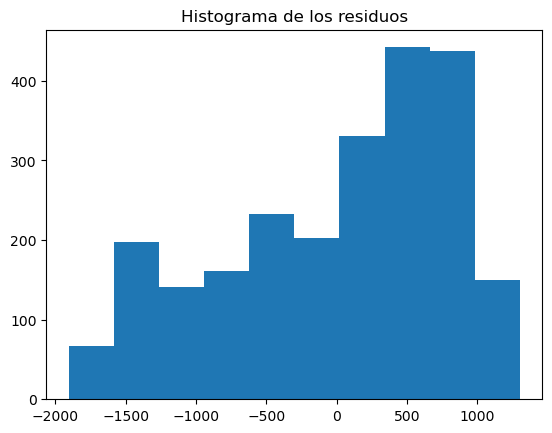

In [25]:
# Análisis de los residuos
SSD = np.sum((df_ecom_encoded["prediction"] - df_ecom_encoded["Total Spend"])**2)
print('SSD: ', SSD)

RSE = np.sqrt(SSD/(len(df_ecom_encoded)-len(feature_cols)-1)) # recordar que tenemos un numero de len(feature_cols) de variables predictoras
print('RSE: ', RSE)

sales_mean = np.mean(df_ecom_encoded["Total Spend"])
error = RSE/sales_mean
print('RSE porcentual: ', round(error,2), '%')

# plot de residuos
plt.hist(df_ecom_encoded['prediction'] - df_ecom_encoded['Total Spend'])
plt.title('Histograma de los residuos')
plt.show()

El RSE porcentual no es muy alto ($\sim$ 13%), aunque los residuos parecen no ser tan normales. Aún queda un poco de mejoría pero no mucho más.

## 🔁 Transformación de variables: más allá de lo lineal

Hasta ahora hemos asumido que la relación entre las variables predictoras y la variable objetivo es aproximadamente lineal. Sin embargo, en muchos casos reales esto no se cumple tan fácilmente. Algunas variables pueden estar **sesgadas**, tener **valores extremos**, o simplemente mostrar una relación no lineal con la respuesta. Si aplicamos una regresión lineal sobre estos datos sin hacer ajustes, el modelo puede tener un mal desempeño y generar conclusiones engañosas.

Aquí es donde entran las **transformaciones de variables**. Aplicar funciones como el logaritmo, la raíz cuadrada o incluso otras más avanzadas puede ayudarnos a:
- Linealizar relaciones que no lo son.
- Estabilizar la varianza (reducir heterocedasticidad).
- Mitigar el efecto de valores atípicos o colas largas.

En esta sección exploraremos cómo aplicar transformaciones sobre variables numéricas usando el dataset clásico `mtcars`, y veremos cómo estas transformaciones pueden mejorar la interpretación y el ajuste del modelo. En este dataset, normalmente la variable objetivo es `mpg`, el rendimiento del auto.

In [26]:
filename = "mtcars/mtcars.csv"
fullpath = os.path.join(mainpath,filename)

df_mtcars = pd.read_csv(fullpath)
df_mtcars.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


Antes de aplicar cualquier transformación, es importante observar cómo se comporta la variable que queremos usar como predictor. En este caso, vamos a explorar la variable `hp` (caballos de fuerza) y cómo se relaciona con el consumo de combustible `mpg`. Esto nos permitirá identificar si la distribución está sesgada o si la relación con la variable objetivo parece no lineal.

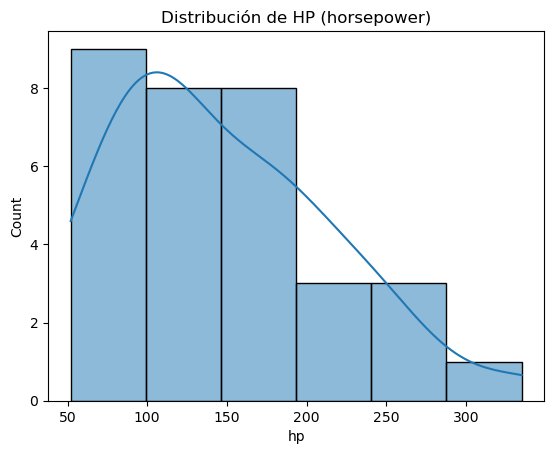

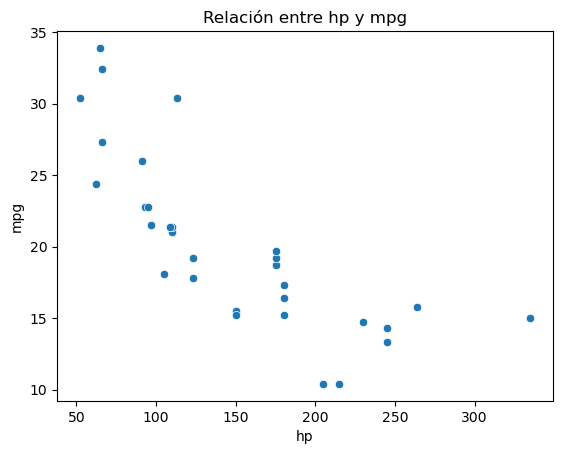

In [27]:
# Visualización de la variable original
sns.histplot(df_mtcars['hp'], kde=True)
plt.title("Distribución de HP (horsepower)")
plt.xlabel("hp")
plt.show()

# Dispersión con mpg (consumo)
sns.scatterplot(x='hp', y='mpg', data=df_mtcars)
plt.title("Relación entre hp y mpg")
plt.xlabel("hp")
plt.ylabel("mpg")
plt.show()

## Aplicando una transformación logarítmica

Una de las transformaciones más comunes cuando las variables están sesgadas o presentan relaciones no lineales es la transformación logarítmica. Al aplicar `log(hp)`, buscamos linealizar la relación con `mpg` y mejorar la estabilidad del modelo. A continuación, observamos cómo cambia la distribución y la relación con la variable objetivo.


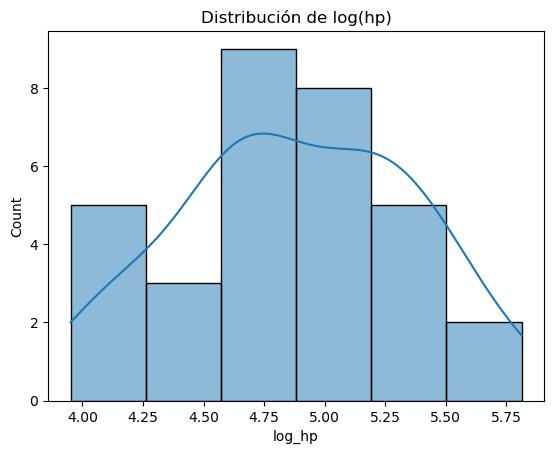

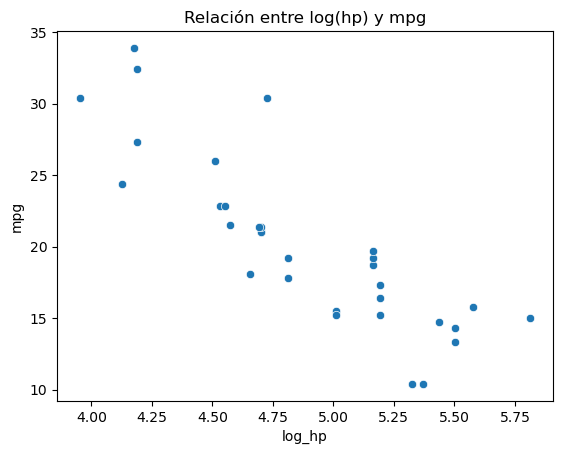

In [28]:
# Añadir columna transformada
df_mtcars['log_hp'] = np.log(df_mtcars['hp'])

# Histograma de la variable transformada
sns.histplot(df_mtcars['log_hp'], kde=True)
plt.title("Distribución de log(hp)")
plt.xlabel("log_hp")
plt.show()

# Dispersión con mpg
sns.scatterplot(x='log_hp', y='mpg', data=df_mtcars)
plt.title("Relación entre log(hp) y mpg")
plt.xlabel("log_hp")
plt.ylabel("mpg")
plt.show()

## Entrenamiento del modelo con la variable transformada

Con la variable `log_hp` ya lista, podemos entrenar un modelo de regresión lineal para predecir `mpg`. Compararemos el rendimiento de este nuevo modelo con el anterior (sin transformación) para ver si hemos logrado un mejor ajuste.


ß0:  30.099
ß1:  -0.068 asociado a variable hp
R²: 0.602437341423934
MSE: 13.989822298268805


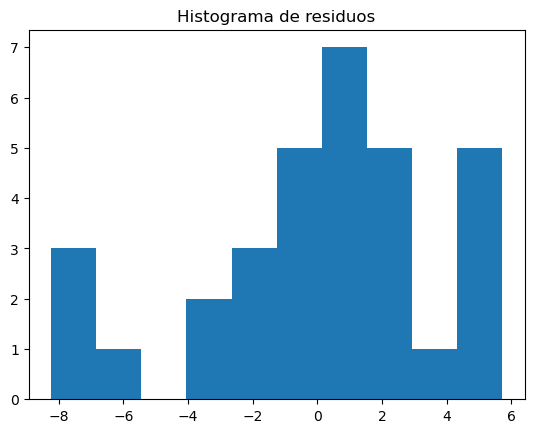

In [29]:
X = df_mtcars[['hp']]
y = df_mtcars['mpg']

model = LinearRegression()
model.fit(X, y)

print('ß0: ', round(model.intercept_,3))
for i in range(0, len(model.coef_)):
    print('ß'+str(i+1)+': ', round(model.coef_[i],3), 'asociado a variable', model.feature_names_in_[i])

y_pred = model.predict(X)

print("R²:", r2_score(y, y_pred))
print("MSE:", mean_squared_error(y, y_pred))

# plot de residuos
plt.hist(y_pred - y)
plt.title('Histograma de residuos')
plt.show()

ß0:  72.64
ß1:  -10.764 asociado a variable log_hp
R²: 0.7204117736506155
MSE: 9.83842299808868


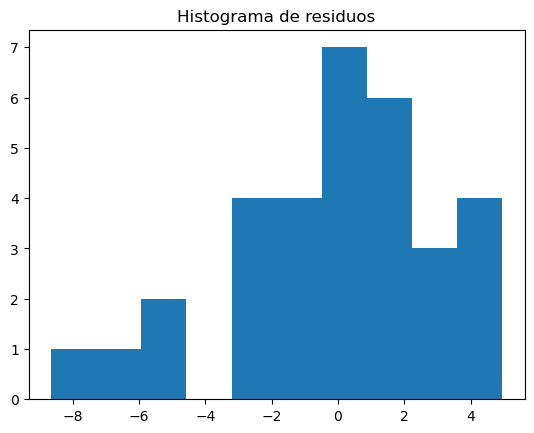

In [30]:
X = df_mtcars[['log_hp']]
y = df_mtcars['mpg']

model = LinearRegression()
model.fit(X, y)

print('ß0: ', round(model.intercept_,3))
for i in range(0, len(model.coef_)):
    print('ß'+str(i+1)+': ', round(model.coef_[i],3), 'asociado a variable', model.feature_names_in_[i])

y_pred = model.predict(X)

print("R²:", r2_score(y, y_pred))
print("MSE:", mean_squared_error(y, y_pred))

# plot de residuos
plt.hist(y_pred - y)
plt.title('Histograma de residuos')
plt.show()

## Conclusión: ¿valió la pena transformar?

Este pequeño experimento nos muestra cómo una transformación adecuada puede mejorar tanto la interpretación como el desempeño de un modelo de regresión lineal. Aunque no siempre será necesaria, conocer y aplicar estas técnicas puede marcar una gran diferencia en modelos del mundo real.

## Transformaciones logarítmicas en modelos lineales

En regresión lineal, el uso de transformaciones logarítmicas puede cambiar tanto la **forma matemática del modelo** como la **interpretación de los coeficientes**. A continuación se presenta una tabla con los cuatro casos más comunes:

| Modelo                             | Ecuación                                                   | Interpretación del coeficiente $\beta_1$                              |
|------------------------------------|-------------------------------------------------------------|------------------------------------------------------------------------|
| **Lineal-Lineal**                 | $\begin{equation} y = \beta_0 + \beta_1 x + \varepsilon \end{equation}$        | Un cambio de una unidad en $x$ produce un cambio de $\beta_1$ unidades en $y$. |
| **Lineal-Log**                    | $\begin{equation} y = \beta_0 + \beta_1 \log(x) + \varepsilon \end{equation}$  | Un cambio del 1% en $x$ se asocia con un cambio aproximado de $\beta_1/100$ en $y$. |
| **Log-Lineal**                    | $\begin{equation} \log(y) = \beta_0 + \beta_1 x + \varepsilon \end{equation}$  | Un cambio de una unidad en $x$ se asocia con un cambio de $100 \cdot \beta_1\%$ en $y$. |
| **Log-Log**                       | $\begin{equation} \log(y) = \beta_0 + \beta_1 \log(x) + \varepsilon \end{equation}$ | Un cambio del 1% en $x$ se asocia con un cambio de aproximadamente $\beta_1\%$ en $y$. |

> 💡 En todos los casos, $\varepsilon$ representa el error aleatorio. Las transformaciones logarítmicas son especialmente útiles cuando las variables tienen distribuciones sesgadas o relaciones no lineales.

Para terminar, en nuestro caso particular, nuestro modelo quedaría de la siguiente forma:

\begin{equation}
\rm{mpg} = 72.64 - 10.764 \ \log(\rm{hp})
\end{equation}

---

## Resumen

- Aprendimos a incorporar variables categóricas a un modelo de regresión lineal utilizando codificación dummy.
- Discutimos la importancia de saber cuál categoría se toma como referencia al eliminar una columna para evitar colinealidad.
- Exploramos transformaciones logarítmicas de variables numéricas para mejorar la linealidad y estabilizar la varianza.
- Analizamos los diferentes modelos lineales (lineal-lineal, log-lineal, etc.) y sus interpretaciones.
- Finalmente, reafirmamos que construir un buen modelo requiere tanto conocimiento técnico como criterio analítico.

---

## Conclusión

A lo largo de este notebook exploramos cómo construir modelos de regresión lineal cuando trabajamos con **variables categóricas** y cómo **transformar variables numéricas** para mejorar la calidad del ajuste. Aprendimos a codificar variables cualitativas con `get_dummies()` y también conocimos una alternativa más flexible con `OneHotEncoder`. Posteriormente, analizamos cómo las **transformaciones logarítmicas** pueden ser una herramienta poderosa para corregir sesgos, linealizar relaciones y mejorar la interpretación del modelo. Además, destacamos cómo la correcta elección y tratamiento de variables puede tener un impacto significativo en el desempeño del modelo.

Este tipo de análisis nos recuerda que el trabajo con modelos no se trata solo de aplicar herramientas automáticamente, sino de **entender los datos, cuestionar sus propiedades y tomar decisiones fundamentadas**. Cada transformación o codificación que hacemos cambia el sentido del modelo, y por eso es tan importante tener una mirada crítica y consciente.


